# Autoregression Forecast Model for Household Electricity Consumption

Execute example for a predictive model for energy consumption

Source: https://machinelearningmastery.com/how-to-develop-an-autoregression-forecast-model-for-household-electricity-consumption/

<b>Keywords:</b> Multi-step forecasting, household consumption, 1 to 7 days forecast

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [44]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if pd.isna(values[row, col]):
                values[row, col] = values[row - one_day, col]
    return

In [31]:
# load all data
dataset = pd.read_csv('../data/household_forecast_example/household_power_consumption.txt', 
                   sep=';', header=0, low_memory=False, infer_datetime_format=True, 
                   parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [34]:
# mark all missing values
dataset.replace('?', np.nan, inplace=True)

# make dataset numeric
dataset = dataset.astype('float32')

# fill missing
fill_missing(dataset.values)

# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

# save updated dataset
dataset.to_csv('../data/household_forecast_example/household_power_consumption.csv')

<b>Load working data</b>

In [45]:
# load the new file
dataset = pd.read_csv('../data/household_forecast_example/household_power_consumption.csv', header=0, 
                      infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

In [46]:
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('../data/household_forecast_example/household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

<b>Evaluation Metric</b>

In [78]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]): 
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = math.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
          for col in range(actual.shape[1]):
                s += (actual[row, col] - predicted[row, col])**2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [56]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

In [51]:
# load the new file
dataset = pd.read_csv('../data/household_forecast_example/household_power_consumption_days.csv', header=0, 
                      infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

In [57]:
# divide data into train and test chunks
train, test = split_dataset(dataset.values)

In [58]:
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


<b>Walk-Forward Validation</b>

The model evaluation is define next

In [59]:
# evaluate a single model
def evaluate_model(model_func, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = np.array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

define function to report scores

In [60]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

convert process data into a flatten vector to check results

In [63]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
    # extract just the total power from each week
    series = [week[:, 0] for week in data]
    # flatten into a single series
    series = np.array(series).flatten()
    return series

In [64]:
# convert training data into a series
series = to_series(train)

In [65]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

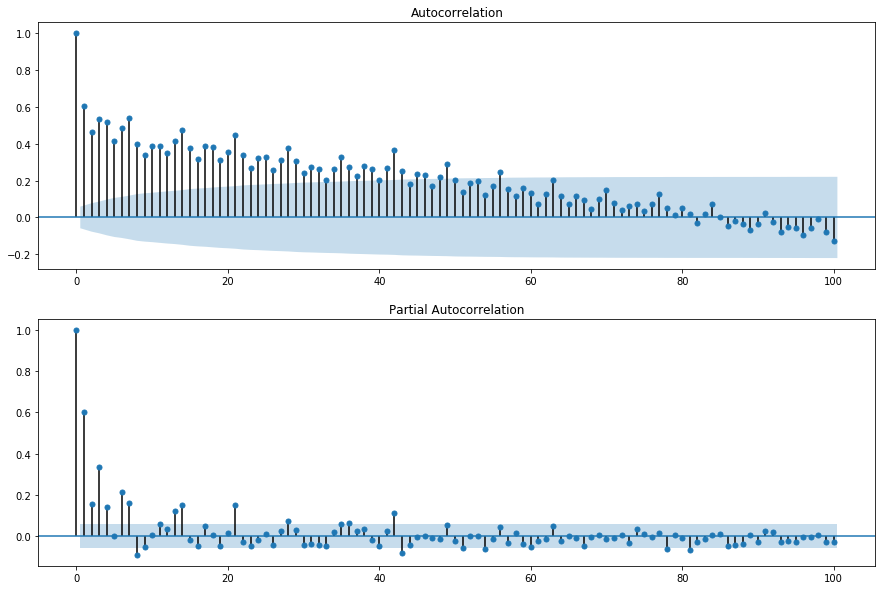

In [71]:
# plots
plt.figure(figsize=(15,10))
lags = 100
# acf
axis = plt.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)
# show plot
plt.show()

We can clearly see a familiar autoregression pattern across the two plots. This pattern is comprised of two elements:
* ACF: A large number of significant lag observations that slowly degrade as the lag increases.
* PACF: A few significant lag observations that abruptly drop as the lag increases.

<b>Develop an Autoregression Model</b>

In [73]:
import math
from statsmodels.tsa.arima_model import ARIMA

In [76]:
# arima forecast
def arima_forecast(history):
    # convert history into a univariate series
    series = to_series(history)
    # define the model
    model = ARIMA(series, order=(7,0,0))
    # fit the model
    model_fit = model.fit(disp=False)
    # make forecast
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

execute model

In [79]:
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast

arima: [381.613] 393.8, 398.9, 357.0, 377.2, 393.8, 306.0, 432.2


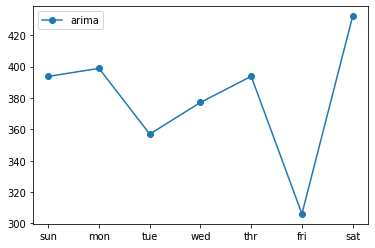

In [80]:
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    plt.plot(days, scores, marker='o', label=name)

# show plot
plt.legend()
plt.show()

In [84]:
train.shape

(159, 7, 8)

In [85]:
test.shape

(46, 7, 8)

In [86]:
train[1,:,:]

array([[2.55001200e+03, 1.49900000e+02, 3.48029910e+05, 1.10022000e+04,
        1.70300000e+03, 5.08200000e+03, 6.89100000e+03, 2.88242000e+04],
       [2.74312000e+03, 2.40280000e+02, 3.50495900e+05, 1.14502000e+04,
        6.62000000e+03, 1.96200000e+03, 5.79500000e+03, 3.13416666e+04],
       [3.93411000e+03, 1.65102000e+02, 3.47940630e+05, 1.63410000e+04,
        1.08600000e+03, 2.53300000e+03, 1.49790000e+04, 4.69705001e+04],
       [1.52876000e+03, 1.78902000e+02, 3.51025000e+05, 6.50520000e+03,
        0.00000000e+00, 3.14000000e+02, 6.97600000e+03, 1.81893333e+04],
       [2.07263800e+03, 2.08876000e+02, 3.50306400e+05, 8.76420000e+03,
        2.20700000e+03, 4.41900000e+03, 9.17600000e+03, 1.87419666e+04],
       [3.17439200e+03, 1.96394000e+02, 3.46854680e+05, 1.33508000e+04,
        1.25200000e+03, 5.16200000e+03, 1.13290000e+04, 3.51635333e+04],
       [2.79610800e+03, 3.12142000e+02, 3.46377150e+05, 1.19526000e+04,
        3.07200000e+03, 7.89300000e+03, 1.25160000e+04, 2.